# Command line interface

The PCNtoolkit is a python package, but it can also be used from the command line. 

Here we show how to use the PCNtoolkit from the command line.

Furthermore, you can use this script to generate commands for the command line interface. (Although if you are able to run this notebook, why not just use it as a python package?)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import pickle

## BLR Example 

### Data preparation

In [2]:
# Download and split data first
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [3]:
data = pd.read_csv("resources/data/fcon1000.csv")

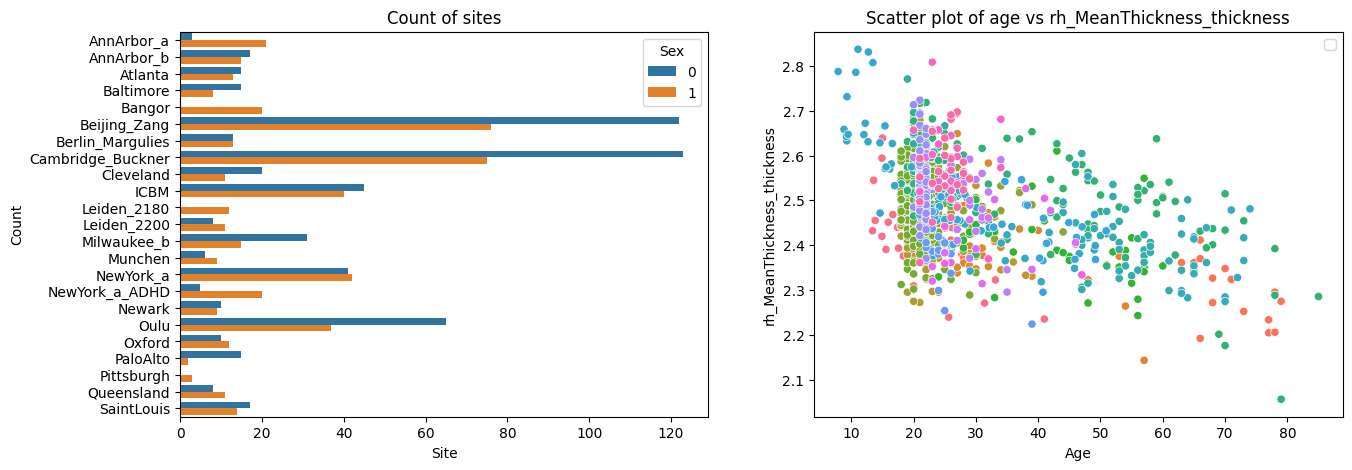

In [4]:
# Inspect the data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=data, x=("age"), y=("rh_MeanThickness_thickness"), hue=("site"), ax=ax[1])
ax[1].legend([], [])
ax[1].set_title("Scatter plot of age vs rh_MeanThickness_thickness")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("rh_MeanThickness_thickness")
sns.countplot(data=data, y="site", hue="sex", ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")
plt.show()

In [5]:
# Split into X, y, and batch effects
covariate_columns = ["age"]
batch_effect_columns = ["sex", "site"]
response_columns = ["rh_MeanThickness_thickness", "WM-hypointensities"]

X = data[covariate_columns]
Y = data[response_columns]
batch_effects = data[batch_effect_columns]

batch_effects_strings = [str(b[0]) + " " + str(b[1]) for b in batch_effects.values]

# Split into train and test set
trainidx, testidx = train_test_split(data.index, test_size=0.2, random_state=42, stratify=batch_effects_strings)
train_X = X.loc[trainidx]
train_Y = Y.loc[trainidx]
train_batch_effects = batch_effects.loc[trainidx]

test_X = X.loc[testidx]
test_Y = Y.loc[testidx]
test_batch_effects = batch_effects.loc[testidx]

In [6]:
# Save stuff
root_dir = os.path.join("resources", "cli_example")
data_dir = os.path.join(root_dir, "data")
os.makedirs(data_dir, exist_ok=True)

resp = os.path.abspath(os.path.join(data_dir, "responses.csv"))
cov = os.path.abspath(os.path.join(data_dir, "covariates.csv"))
be = os.path.abspath(os.path.join(data_dir, "batch_effects.csv"))

t_resp = os.path.abspath(os.path.join(data_dir, "test_responses.csv"))
t_cov = os.path.abspath(os.path.join(data_dir, "test_covariates.csv"))
t_be = os.path.abspath(os.path.join(data_dir, "test_batch_effects.csv"))


with open(cov, "wb") as f:
    pickle.dump(train_X, f)
with open(resp, "wb") as f:
    pickle.dump(train_Y, f)
with open(be, "wb") as f:
    pickle.dump(train_batch_effects, f)
with open(t_cov, "wb") as f:
    pickle.dump(test_X, f)
with open(t_resp, "wb") as f:
    pickle.dump(test_Y, f)
with open(t_be, "wb") as f:
    pickle.dump(test_batch_effects, f)

### BLR configuration

In [16]:
alg = "blr"
func = "fit_predict"

# normative model configuration
save_dir = os.path.join(root_dir, "blr_cli", "save_dir")
savemodel = True
saveresults = True
basis_function = "linear"
inscaler = "standardize"
outscaler = "standardize"

# Regression model configuration
optimizer = "l-bfgs-b"
n_iter = 200
heteroskedastic = True
fixed_effect = True
warp = "WarpSinhArcsinh"
warp_reparam = True

# runner configuration
cross_validate = True
cv_folds = 5
parallelize = False
job_type = "local"
n_jobs = 2
temp_dir = os.path.join(root_dir, "temp")
log_dir = os.path.join(root_dir, "log")
python_env = os.path.join(os.path.dirname(os.path.dirname(sys.executable)))

### Constructing command

In [17]:
command = "normative"
args = f"-a {alg} -f {func} -c {cov} -r {resp} -t {t_resp} -e {t_cov} -k {cv_folds}"
kwargs = f"be={be} t_be={t_be}"
normative_model_kwargs = f"save_dir={save_dir} savemodel={savemodel} saveresults={saveresults} basis_function={basis_function} inscaler={inscaler} outscaler={outscaler}"
runner_kwargs = f"cross_validate={cross_validate} parallelize={parallelize} job_type={job_type} n_jobs={n_jobs} temp_dir={temp_dir} log_dir={log_dir} environment={python_env}"
blr_kwargs = f"optimizer={optimizer} n_iter={n_iter} heteroskedastic={heteroskedastic} fixed_effect={fixed_effect} warp={warp} warp_reparam={warp_reparam}"
full_command = f"{command} {args} {kwargs} {runner_kwargs} {normative_model_kwargs} {blr_kwargs}"

In [18]:
print(full_command)

normative -a blr -f fit_predict -c /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/covariates.csv -r /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/responses.csv -t /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_responses.csv -e /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_covariates.csv -k 5 be=/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/batch_effects.csv t_be=/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_batch_effects.csv cross_validate=True parallelize=False job_type=local n_jobs=2 temp_dir=resources/cli_example/temp log_dir=resources/cli_example/log environment=/opt/anaconda3/envs/uv_refactor save_dir=resources/cli_example/blr_cli/save_dir savemodel=True saveresults=True basis_function=linear inscaler=standardize outscaler=standardize optimizer=l-bfgs-b n_iter=200 heteroske

### Running command

In [19]:
!{full_command}

Process: 30436 - 2025-06-24 12:23:35 - Dataset "fit_data" created.
    - 862 observations
    - 862 unique subjects
    - 1 covariates
    - 2 response variables
    - 2 batch effects:
    	batch_effect_0 (2)
	batch_effect_1 (23)
    
Process: 30436 - 2025-06-24 12:23:35 - Dataset "predict_data" created.
    - 216 observations
    - 216 unique subjects
    - 1 covariates
    - 2 response variables
    - 2 batch effects:
    	batch_effect_0 (2)
	batch_effect_1 (23)
    
Process: 30436 - 2025-06-24 12:23:35 - Task ID created: fit_predict_fit_data__2025-06-24_12:23:35_271.957031
Process: 30436 - 2025-06-24 12:23:35 - Temporary directory created:
	/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/temp/fit_predict_fit_data__2025-06-24_12:23:35_271.957031
Process: 30436 - 2025-06-24 12:23:35 - Log directory created:
	/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/log/fit_predict_fit_data__2025-06-24_12:23:35_271.957031
/opt/anaconda3/envs/uv

You can find the results in the resources/cli_example/blr/save_dir folder.

In [21]:
import pandas as pd

a = pd.read_csv(
    "/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/blr_cli/save_dir/folds/fold_1/results/statistics_fit_data_fold_1_predict.csv",
    index_col=0,
)

## HBR example

In [22]:
alg = "hbr"
func = "fit_predict"

# normative model configuration
save_dir = os.path.join(root_dir, "hbr", "save_dir")
savemodel = True
saveresults = True
basis_function = "bspline"
inscaler = "standardize"
outscaler = "standardize"


# Regression model configuration
draws = 1000
tune = 500
chains = 4
nuts_sampler = "nutpie"

likelihood = "Normal"
linear_mu = "True"
random_intercept_mu = "True"
random_slope_mu = "False"
linear_sigma = "True"
random_intercept_sigma = "False"
random_slope_sigma = "False"

### Constructing command

In [23]:
command = "normative"
args = f"-a {alg} -f {func} -c {cov} -r {resp} -t {t_resp} -e {t_cov}"
kwargs = f"be={be} t_be={t_be}"
normative_model_kwargs = f"save_dir={save_dir} savemodel={savemodel} saveresults={saveresults} basis_function={basis_function} inscaler={inscaler} outscaler={outscaler}"
hbr_kwargs = f"draws={draws} tune={tune} chains={chains} nuts_sampler={nuts_sampler} likelihood={likelihood} linear_mu={linear_mu} random_intercept_mu={random_intercept_mu} random_slope_mu={random_slope_mu} linear_sigma={linear_sigma} random_intercept_sigma={random_intercept_sigma} random_slope_sigma={random_slope_sigma}"
full_command = f"{command} {args} {kwargs} {normative_model_kwargs} {hbr_kwargs}"
print(full_command)

normative -a hbr -f fit_predict -c /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/covariates.csv -r /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/responses.csv -t /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_responses.csv -e /Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_covariates.csv be=/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/batch_effects.csv t_be=/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/resources/cli_example/data/test_batch_effects.csv save_dir=resources/cli_example/hbr/save_dir savemodel=True saveresults=True basis_function=bspline inscaler=standardize outscaler=standardize draws=1000 tune=500 chains=4 nuts_sampler=nutpie likelihood=Normal linear_mu=True random_intercept_mu=True random_slope_mu=False linear_sigma=True random_intercept_sigma=False random_slope_sigma=False


### Running command


In [24]:
!{full_command}

Process: 31517 - 2025-06-24 12:26:40 - No log directory specified. Using default log directory: /Users/stijndeboer/.pcntoolkit/logs
Process: 31517 - 2025-06-24 12:26:40 - No temporary directory specified. Using default temporary directory: /Users/stijndeboer/.pcntoolkit/temp
Process: 31517 - 2025-06-24 12:26:40 - Dataset "fit_data" created.
    - 862 observations
    - 862 unique subjects
    - 1 covariates
    - 2 response variables
    - 2 batch effects:
    	batch_effect_0 (2)
	batch_effect_1 (23)
    
Process: 31517 - 2025-06-24 12:26:40 - Dataset "predict_data" created.
    - 216 observations
    - 216 unique subjects
    - 1 covariates
    - 2 response variables
    - 2 batch effects:
    	batch_effect_0 (2)
	batch_effect_1 (23)
    
Process: 31517 - 2025-06-24 12:26:40 - Task ID created: fit_predict_fit_data__2025-06-24_12:26:40_941.230957
Process: 31517 - 2025-06-24 12:26:40 - Temporary directory created:
	/Users/stijndeboer/.pcntoolkit/temp/fit_predict_fit_data__2025-06-24_12: